In [ ]:
import torch

if torch.cuda.is_available():
    print("CUDA is available. Number of GPUs:", torch.cuda.device_count())
    print("Current GPU:", torch.cuda.current_device())
    print("GPU Name:", torch.cuda.get_device_name(torch.cuda.current_device()))
else:
    print("CUDA is not available. PyTorch is using the CPU.")


In [5]:
import json

# Read the JSON file
with open('/home/mb5018/long-doc-summ/fd-summaries.json', 'r') as f:
    summaries_data = json.load(f)

# Extract the summaries into a list
fd_summaries = [sample['summary'] for sample in summaries_data['samples']]

# Now summaries_list contains the list of summaries
average_length = sum(len(summary.split()) for summary in fd_summaries) / len(fd_summaries)
average_length

80.5

In [6]:
import json

# Read the JSON file
with open('/home/mb5018/long-doc-summ/tms-summaries.json', 'r') as f:
    summaries_data = json.load(f)

# Extract the summaries into a list
tms_summaries = [sample['summary'] for sample in summaries_data['samples']]

# Now summaries_list contains the list of summaries
average_length = sum(len(summary.split()) for summary in tms_summaries) / len(tms_summaries)
average_length

223.85

In [13]:
%pip install nltk

  Using cached nltk-3.8.1-py3-none-any.whl (1.5 MB)
  Using cached click-8.1.6-py3-none-any.whl (97 kB)
You should consider upgrading via the '/home/mb5018/long-doc-summ/myenv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
# NEEDS EDITING
import csv
from nltk.tokenize import sent_tokenize

def write_tsv(text, output_file, segment_size):
    with open(output_file, 'w', newline='', encoding='utf-8') as file:
        writer = csv.writer(file, delimiter='\t')
        writer.writerow(['id', 'context', 'sentence'])

        # Splitting the text into sentences
        sentences = sent_tokenize(text)

        # Looping through the sentences to create the context dynamically
        context = ''
        segment = []
        for index, sentence in enumerate(sentences):
            segment.append(sentence)

            # Check if segment is complete
            if len(segment) == segment_size:
                writer.writerow([index, context.strip(), ' '.join(segment)])
                context += ' ' + ' '.join(segment)
                segment = []

        # Writing any remaining sentences if they don't form a complete segment
        if segment:
            writer.writerow([index, context.strip(), ' '.join(segment)])

# Text input
text = """In his younger years, Hardy's father gave him advice that he has been turning over in his mind ever since. Whenever he feels like criticizing anyone, he should remember that all people in the world haven't had the advantages he has. Hardy lives at West Egg, the less fashionable of the two, and his house is an eyesore, but it has a view of the water and the comforting proximity of millionaires. One evening, Hardy drives over to East Egg to see two old friends, Tom Buchanan and Daisy. Tom and Daisy stroll back into the library as if to a vigil beside a perfectly tangible body."""

# Segment sizes
segment_sizes = [2, 3, 4]

# Creating the files for different segment sizes
for size in segment_sizes:
    output_file = f'sample_{size}_sentences.tsv'
    write_tsv(text, output_file, size)


In [24]:
import csv
from nltk.tokenize import sent_tokenize

def preprocess(text):
        out = []
        # Splitting the text into sentences
        sentences = sent_tokenize(text)

        # Looping through the sentences to create the context dynamically
        context = ''
        for index, sentence in enumerate(sentences):
            out.append({"id":index, "context":context.strip(), "sentence":sentence})
            context += ' ' + sentence
        return out

text = """In his younger years, Hardy's father gave him advice that he has been turning over in his mind ever since. Whenever he feels like criticizing anyone, he should remember that all people in the world haven't had the advantages he has. Hardy lives at West Egg, the less fashionable of the two, and his house is an eyesore, but it has a view of the water and the comforting proximity of millionaires. One evening, Hardy drives over to East Egg to see two old friends, Tom Buchanan and Daisy. Tom and Daisy stroll back into the library as if to a vigil beside a perfectly tangible body."""

preprocess(text)


[{'id': 0,
  'context': '',
  'sentence': "In his younger years, Hardy's father gave him advice that he has been turning over in his mind ever since."},
 {'id': 1,
  'context': "In his younger years, Hardy's father gave him advice that he has been turning over in his mind ever since.",
  'sentence': "Whenever he feels like criticizing anyone, he should remember that all people in the world haven't had the advantages he has."},
 {'id': 2,
  'context': "In his younger years, Hardy's father gave him advice that he has been turning over in his mind ever since. Whenever he feels like criticizing anyone, he should remember that all people in the world haven't had the advantages he has.",
  'sentence': 'Hardy lives at West Egg, the less fashionable of the two, and his house is an eyesore, but it has a view of the water and the comforting proximity of millionaires.'},
 {'id': 3,
  'context': "In his younger years, Hardy's father gave him advice that he has been turning over in his mind ever si

In [25]:
example = preprocess(text)

In [31]:
import argparse
import logging

import pandas as pd
import numpy as np
import torch
from torch import nn
import os
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler, WeightedRandomSampler
from tqdm.auto import tqdm
import csv
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from transformers import (
    T5Tokenizer,
    T5ForConditionalGeneration,
    SchedulerType,
    get_scheduler,
    set_seed,
)

logger = logging.getLogger(__name__)
softmax_func = nn.Softmax(dim=1)

model_name_or_path = "/home/mb5018/long-doc-summ/snac-main/t5-span"
max_length = 1024
per_device_eval_batch_size = 8

def load_dataset(data_file):
    reader = csv.DictReader(open(data_file), delimiter='\t')
    examples = [row for row in reader]
    return examples


def evaluate(model, eval_dataloader, tokenizer):
    model.eval()

    results = []

    for step, batch in tqdm(enumerate(eval_dataloader), desc='Evaluation'):
        batch = tuple(t.to(device) for t in batch)
        input_ids, attention_mask = batch[0], batch[1]
        inp = {'input_ids': input_ids, 'attention_mask': attention_mask}
        with torch.no_grad():
            outputs = model.generate(**inp, max_length=80)
            predictions_gen = [tokenizer.decode(outputs[i], skip_special_tokens=False) for i in range(outputs.shape[0])]

            for inp, p in zip(input_ids, predictions_gen):
                inp = tokenizer.decode(inp, skip_special_tokens=False).replace('<pad>', '').strip()
                p = p.replace('<pad>', '').strip()
                results.append({
                    'input': inp, 
                    'prediction': p
                })

    return results



def process_data(data_raw):
        texts = []
        for row_idx, row in enumerate(data_raw):
            #print(row)
            text_temp = ' '.join(row['context'].split()[-int(0.9 * max_length):]) + \
                        ' <extra_id_0> ' + row['sentence']
            texts.append(text_temp)

        texts = tokenizer(texts, max_length=max_length, truncation=True,
                          padding='max_length', return_tensors='pt')

        input_ids, attention_mask = texts.input_ids, texts.attention_mask
        dataset = TensorDataset(input_ids, attention_mask)
        return dataset



val_data_raw = example
print(len(val_data_raw))

tokenizer = T5Tokenizer.from_pretrained(model_name_or_path)
model = T5ForConditionalGeneration.from_pretrained(model_name_or_path)

device = 'cuda'
model.to(device)

eval_dataset = process_data(val_data_raw)
eval_sampler = SequentialSampler(eval_dataset)
eval_dataloader = DataLoader(eval_dataset, sampler=eval_sampler, batch_size=per_device_eval_batch_size)

results = evaluate(model, eval_dataloader, tokenizer)

5


Evaluation: 1it [00:01,  1.09s/it]


In [32]:
tokenizer = T5Tokenizer.from_pretrained(model_name_or_path)
model = T5ForConditionalGeneration.from_pretrained(model_name_or_path)
device = 'cuda'
model.to(device)
  
  
def pipeline(text):
  example = preprocess(text)
  val_data_raw = example

  eval_dataset = process_data(val_data_raw)
  eval_sampler = SequentialSampler(eval_dataset)
  eval_dataloader = DataLoader(eval_dataset, sampler=eval_sampler, batch_size=per_device_eval_batch_size)

  results = evaluate(model, eval_dataloader, tokenizer)
  return results

In [33]:
all_results = []
for summary in fd_summaries:
  all_results.append(pipeline(summary))

Evaluation: 0it [00:00, ?it/s]

Evaluation: 1it [00:00,  1.18it/s]
Evaluation: 2it [00:02,  1.26s/it]
Evaluation: 1it [00:01,  1.18s/it]
Evaluation: 1it [00:01,  1.22s/it]
Evaluation: 1it [00:00,  1.07it/s]
Evaluation: 1it [00:00,  4.54it/s]
Evaluation: 1it [00:00,  1.26it/s]
Evaluation: 1it [00:00,  1.87it/s]
Evaluation: 1it [00:00,  2.46it/s]
Evaluation: 1it [00:01,  1.22s/it]
Evaluation: 1it [00:00,  4.50it/s]
Evaluation: 1it [00:00,  1.01it/s]
Evaluation: 1it [00:00,  1.51it/s]
Evaluation: 2it [00:03,  1.53s/it]
Evaluation: 1it [00:00,  2.11it/s]
Evaluation: 1it [00:00,  2.62it/s]
Evaluation: 2it [00:02,  1.18s/it]
Evaluation: 1it [00:00,  1.07it/s]
Evaluation: 1it [00:01,  1.01s/it]
Evaluation: 1it [00:00,  1.25it/s]


In [36]:
all_results[0]

[{'input': '<extra_id_0> The TARDIS arrives in Little Hodcombe, Tegan wants to visit her Grandfather while they are there.</s>',
  'prediction': 'false<extra_id_0> character Tegan Grandfather<extra_id_0> event The TARDIS arrives in Little Hodcombe</s>'},
 {'input': 'The TARDIS arrives in Little Hodcombe, Tegan wants to visit her Grandfather while they are there.<extra_id_0> Also, a war re-enactment is going on that starts to get more and more out of hand and realistic for unknown reasons.</s>',
  'prediction': 'true</s>'}]

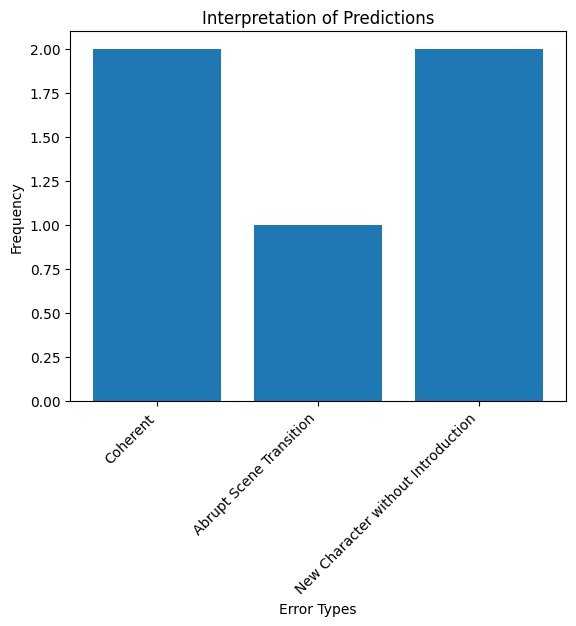

In [11]:
import matplotlib.pyplot as plt

# Sample data
data = [
    ("In his younger years, Hardy's father...", "false<extra_id_0> character Hardy</s>"),
    ("In his younger years, Hardy's father...", "true</s>"),
    ("In his younger years, Hardy's father...", "false<extra_id_0> scene</s>"),
    ("In his younger years, Hardy's father...", "false<extra_id_0> character Tom Buchanan Daisy</s>"),
    ("In his younger years, Hardy's father...", "true</s>")
]

# Function to interpret the result
def interpret_result(text, prediction):
    if "true" in prediction:
        return "Coherent"
    elif "character" in prediction:
        return "New Character without Introduction"
    elif "scene" in prediction:
        return "Abrupt Scene Transition"
    else:
        return "Unknown Error"

# Storing the interpretation
interpretations = [interpret_result(text, prediction) for text, prediction in data]

# Counting the occurrences for visualization
interpretation_counts = {interpretation: interpretations.count(interpretation) for interpretation in set(interpretations)}

# Plotting
plt.bar(interpretation_counts.keys(), interpretation_counts.values())
plt.title('Interpretation of Predictions')
plt.xlabel('Error Types')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.show()
